# Import Modules

In [20]:
import pandas as pd
import sqlite3
from matplotlib import pyplot as plt
import math

# Loading Data into Data Frames and SQL Tables

In [21]:
conn = sqlite3.connect('fetch.db')
cursor = conn.cursor()

In [22]:
# loading products
products = pd.read_csv('PRODUCTS_TAKEHOME.csv')
print("File loaded successfully!")
products.head() # Display first few rows for verification

File loaded successfully!


,CATEGORY_1,CATEGORY_2,CATEGORY_3,CATEGORY_4,MANUFACTURER,BRAND,BARCODE
0,Health & Wellness,Sexual Health,Conductivity Gels & Lotions,NaN,NaN,NaN,7.964944e+11
1,Snacks,Puffed Snacks,Cheese Curls & Puffs,NaN,NaN,NaN,2.327801e+10
2,Health & Wellness,Hair Care,Hair Care Accessories,NaN,PLACEHOLDER MANUFACTURER,ELECSOP,4.618178e+11
3,Health & Wellness,Oral Care,Toothpaste,NaN,COLGATE-PALMOLIVE,COLGATE,3.500047e+10
4,Health & Wellness,Medicines & Treatments,Essential Oils,NaN,MAPLE HOLISTICS AND HONEYDEW PRODUCTS INTERCHA...,MAPLE HOLISTICS,8.068109e+11


In [23]:
products.to_sql('products', conn, if_exists='replace', index=False)

845552

In [24]:
# loading transactions
transactions = pd.read_csv('TRANSACTION_TAKEHOME.csv')
print("File loaded successfully!")
transactions.head() # Display first few rows for verification

File loaded successfully!


,RECEIPT_ID,PURCHASE_DATE,SCAN_DATE,STORE_NAME,USER_ID,BARCODE,FINAL_QUANTITY,FINAL_SALE
0,0000d256-4041-4a3e-adc4-5623fb6e0c99,2024-08-21,2024-08-21 14:19:06.539 Z,WALMART,63b73a7f3d310dceeabd4758,1.530001e+10,1.00,
1,0001455d-7a92-4a7b-a1d2-c747af1c8fd3,2024-07-20,2024-07-20 09:50:24.206 Z,ALDI,62c08877baa38d1a1f6c211a,NaN,zero,1.49
2,00017e0a-7851-42fb-bfab-0baa96e23586,2024-08-18,2024-08-19 15:38:56.813 Z,WALMART,60842f207ac8b7729e472020,7.874223e+10,1.00,
3,000239aa-3478-453d-801e-66a82e39c8af,2024-06-18,2024-06-19 11:03:37.468 Z,FOOD LION,63fcd7cea4f8442c3386b589,7.833997e+11,zero,3.49
4,00026b4c-dfe8-49dd-b026-4c2f0fd5c6a1,2024-07-04,2024-07-05 15:56:43.549 Z,RANDALLS,6193231ae9b3d75037b0f928,4.790050e+10,1.00,


In [25]:
transactions.to_sql('transactions', conn, if_exists='replace', index=False)

50000

In [26]:
# loading users
users = pd.read_csv('USER_TAKEHOME.csv')
print("File loaded successfully!")
users.head() # Display first few rows for verification

File loaded successfully!


,ID,CREATED_DATE,BIRTH_DATE,STATE,LANGUAGE,GENDER
0,5ef3b4f17053ab141787697d,2020-06-24 20:17:54.000 Z,2000-08-11 00:00:00.000 Z,CA,es-419,female
1,5ff220d383fcfc12622b96bc,2021-01-03 19:53:55.000 Z,2001-09-24 04:00:00.000 Z,PA,en,female
2,6477950aa55bb77a0e27ee10,2023-05-31 18:42:18.000 Z,1994-10-28 00:00:00.000 Z,FL,es-419,female
3,658a306e99b40f103b63ccf8,2023-12-26 01:46:22.000 Z,NaN,NC,en,NaN
4,653cf5d6a225ea102b7ecdc2,2023-10-28 11:51:50.000 Z,1972-03-19 00:00:00.000 Z,PA,en,female


In [27]:
users.to_sql('users', conn, if_exists='replace', index=False)

100000

# First: Exploring the Data

### Products

In [28]:
# Checking for missing values
products.isnull().sum()

,0
CATEGORY_1,111
CATEGORY_2,1424
CATEGORY_3,60566
CATEGORY_4,778093
MANUFACTURER,226474
BRAND,226472
BARCODE,4025


There are many missing values in the products table. The barcode field is especially problematic because it is the foreign key that connects to the transactions table.

In [29]:
# Checking for duplicate rows
print(f"\nNumber of duplicate rows: {products.BARCODE.duplicated().sum()}")


Number of duplicate rows: 4209


Fortunately, not a lot of duplicated rows in here

Let's find out the number of items per major category

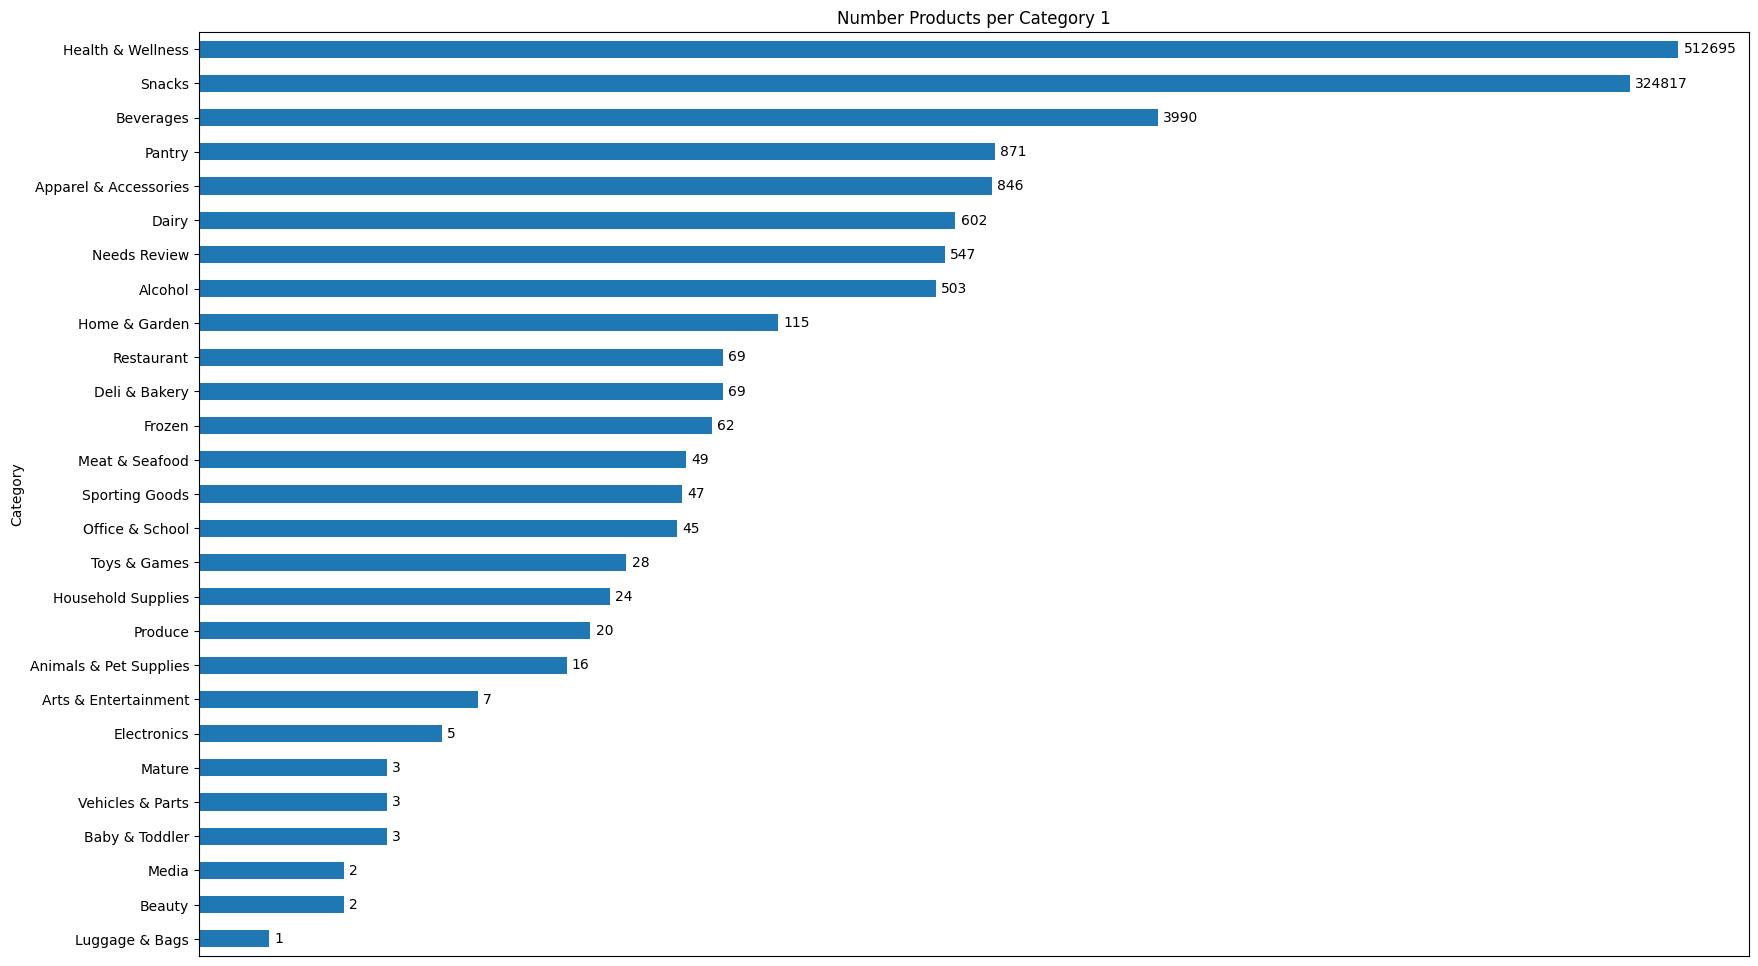

In [30]:
plt.figure(figsize=(20, 12))
plot_data = products['CATEGORY_1'].value_counts().sort_values()
# print(plot_data.tail())

bar_plot = plot_data.plot(kind='barh')
plt.title('Number Products per Category 1')
plt.ylabel('Category')
plt.xscale('log')
bar_plot.xaxis.set_visible(False)

for bp in bar_plot.patches:
    bar_plot.text(1.05*bp.get_width(), (bp.get_y() + bp.get_height()/2), f"{int(bp.get_width())}", ha="left", va="center")

plt.show()

The _Health and Wellness_ and _Snacks_ appear to be the major categories. However, the gap between the products per category in the top-most and bottom most category is too wide. This could lead to under-representation for the products beyond the top categories.

In [31]:
# The percentage of items belonging to the top 3 in Category_1
products_in_top_3 = products[products['CATEGORY_1'].isin(plot_data.nlargest(3).index)]
percentage_top_3 = (len(products_in_top_3) / len(products)) * 100
print(f"Percentage of items in the top 3 categories: {percentage_top_3:.2f}%")


Percentage of items in the top 3 categories: 99.52%


In [32]:
manufacturer_counts = products.MANUFACTURER.value_counts().sort_values(ascending=False)
manufacturer_counts.head()

,count
MANUFACTURER,
PLACEHOLDER MANUFACTURER,86902
PROCTER & GAMBLE,21065
REM MANUFACTURER,20813
UNILEVER,16864
L'OREAL,16699


Here, `PLACEHOLDER MANUFACTURER` and `REM MANUFACTURER` are the most frequently appearing manufacturers. These hint at default-populated values instead of the actual manufacturer names. This is a key area of improvement for future data gathering.

In [33]:
brand_counts = products.BRAND.value_counts(ascending=False)
brand_counts.head()

,count
BRAND,
REM BRAND,20813
BRAND NOT KNOWN,17025
PRIVATE LABEL,13467
CVS,6400
SEGO,4831


Here, `REM BRAND`, `BRAND NOT KNOWN` and `PRIVATE LABEL` are the most frequently appearing brands. These also hint at default-populated values instead of the actual brand names. This too, is a key area of improvement for future data collection.

### Users

In [34]:
users.isnull().sum()

,0
ID,0
CREATED_DATE,0
BIRTH_DATE,3675
STATE,4812
LANGUAGE,30508
GENDER,5892


In [35]:
users.duplicated().sum()

0

Absence of duplicated rows is a good sign in the data collection of users.

In [36]:
state_counts = users.STATE.value_counts().sort_values(ascending=False)
print(state_counts.head())
print('\n')
print(state_counts.tail())

STATE
TX    9028
FL    8921
CA    8589
NY    5703
IL    3794
Name: count, dtype: int64


STATE
SD    205
ND    185
MT    169
WY    138
VT    111
Name: count, dtype: int64


In the code result above, we can see that the gap between the top and bottom states that users signed up is huge. This again could lead to under-representation for any demographic analyses in the future.

In [37]:
# Percentage of sign-ups belonging to the top 5 states
top_5_states = state_counts.head(5)
percentage_signups_top_5 = (state_counts.head(5).sum() / state_counts.sum()) * 100

print(f"Percentage of sign-ups from the top 5 states among the {len(state_counts)} states present in the data: {percentage_signups_top_5:.2f}%")


Percentage of sign-ups from the top 5 states among the 52 states present in the data: 37.86%


In [38]:
users.GENDER.value_counts().sort_values(ascending=False)

,count
GENDER,
female,64240
male,25829
transgender,1772
prefer_not_to_say,1350
non_binary,473
unknown,196
not_listed,180
Non-Binary,34
not_specified,28


In the summarized table above, there are redundant values of similar choices, such as :
*  `prefer_not_to_say` and `Prefer not to say`,
*  `non_binary` and `Non-Binary`
*  `not_listed`, `not_specified`, and `My gender isn't listed`

This could cause confusions in DEI analysis performed on the users data to better understand the user demographics

### Transactions

In [39]:
transactions.isnull().sum()

,0
RECEIPT_ID,0
PURCHASE_DATE,0
SCAN_DATE,0
STORE_NAME,0
USER_ID,0
BARCODE,5762
FINAL_QUANTITY,0
FINAL_SALE,0


Having null values in barcode field is problematic because according to the ER-diagram, it is the foreign-key connecting the products table to the transactions table.

In [40]:
len(transactions), transactions[['RECEIPT_ID','USER_ID']].duplicated().sum()

(50000, 25560)

Here, we see that among the total `50000` transactions in the table, `255560` - more than 50% of the transaction receipts and users - are duplicate. This could lead to unreliable results for any aggregate analysis on the transactions table.

# Second: Provide SQL Queries

## Closed-ended questions

### What are the top 5 brands by receipts scanned among users 21 and over?

In [41]:
top_5_brands_of_users_21_and_above_query = """
SELECT p.brand, COUNT(DISTINCT t.receipt_id) AS num_receipts
FROM transactions t JOIN products p USING(barcode)
JOIN users u ON t.user_id = u.id
where t.scan_date - u.birth_date >= 21
and p.brand is not null
GROUP BY p.brand
ORDER BY num_receipts DESC
LIMIT 5;
"""

cursor.execute(top_5_brands_of_users_21_and_above_query)
top_5_brands_of_users_21_and_above_results = cursor.fetchall()

print("Top 5 brands by receipts scanned among users aged 21 and over:")
for i,row in enumerate(top_5_brands_of_users_21_and_above_results):
    print(f'{i+1}. {row[0]}')

Top 5 brands by receipts scanned among users aged 21 and over:
1. NERDS CANDY
2. DOVE
3. TRIDENT
4. SOUR PATCH KIDS
5. MEIJER


### What are the top 5 brands by sales among users that have had their account for at least six months?

In [42]:
top_5_brands_6_months_query = """
SELECT p.brand, SUM(t.final_sale) AS total_sales
FROM transactions t
JOIN products p ON t.barcode = p.barcode
JOIN users u ON t.user_id = u.id
WHERE t.scan_date >= date(u.created_date, '+6 months')
and p.brand is not null
GROUP BY p.brand
ORDER BY total_sales DESC
LIMIT 5;
"""

cursor.execute(top_5_brands_6_months_query)
top_5_brands_6_months_results = cursor.fetchall()

print("Top 5 brands by sales among users with accounts for at least six months:")
for i, row in enumerate(top_5_brands_6_months_results):
    print(f"{i+1}. {row[0]}")

Top 5 brands by sales among users with accounts for at least six months:
1. CVS
2. TRIDENT
3. DOVE
4. COORS LIGHT
5. AXE


### What is the percentage of sales in the Health & Wellness category by generation?

In [43]:
# What is the percentage of sales in the Health & Wellness category by generation?
sales_percent_hnw_per_generation_query = """
SELECT
    CASE
        WHEN strftime('%Y', birth_date) BETWEEN '1946' AND '1964' THEN 'Baby Boomers'
        WHEN strftime('%Y', birth_date) BETWEEN '1965' AND '1980' THEN 'Generation-X'
        WHEN strftime('%Y', birth_date) BETWEEN '1981' AND '1996' THEN 'Millennials'
        ELSE 'Other'
    END AS generation,
    ROUND((SUM(t.final_sale) * 100.0 / (SELECT SUM(t.final_sale) FROM transactions t JOIN users u ON t.user_id = u.id JOIN products p USING(barcode) WHERE p.category_1 = 'Health & Wellness')),2) AS sales_percentage
FROM transactions t
JOIN users u ON t.user_id = u.id
JOIN products p USING(barcode)
WHERE p.category_1 = 'Health & Wellness'
GROUP BY generation
ORDER BY generation DESC;
"""

cursor = conn.cursor()
cursor.execute(sales_percent_hnw_per_generation_query)
sales_percent_hnw_per_generation_results = cursor.fetchall()

print("Percentage of sales in the Health & Wellness category by generation:")
for i, row in enumerate(sales_percent_hnw_per_generation_results):
    print(f"{i+1}. {row[0]} with {row[1]}%")


Percentage of sales in the Health & Wellness category by generation:
1. Millennials with 31.18%
2. Generation-X with 21.88%
3. Baby Boomers with 46.94%


## Open Ended Questions

### Who are Fetch’s power users?

There are many ways to interpret power users of Fetch. Here, I am assuming two ways a user could be categorized as a power user.
1. __App Engagement:__ Number of receipts scanned by a user
2. __Purchase Spend:__ Total purchase value of the receipts scanned by a user

#### Assumption #1: _Power users scanned 5x more receipts than the median number of receipts scanned by a single user_

In [44]:
# Median number of receipts scanned per user
median_receipts_query = """
SELECT CAST(COUNT(distinct receipt_id) AS REAL) / COUNT(DISTINCT user_id)
FROM transactions;
"""
cursor.execute(median_receipts_query)
median_receipts_result = cursor.fetchone()[0]
print(f"The median number of receipts scanned per user is: {math.ceil(median_receipts_result)}\n")

# Users who scanned 5x more receipts than the median user
power_users_by_engagement_query = f"""
SELECT user_id, COUNT(distinct receipt_id) AS receipts_scanned
FROM transactions
GROUP BY user_id
HAVING receipts_scanned >= {median_receipts_result * 5}
ORDER BY receipts_scanned DESC;
"""

cursor.execute(power_users_by_engagement_query)
power_users_by_engagement_results = cursor.fetchall()

print("Fetch's power users (scanned 5 times more receipts than the median user):")
user_engagement_df = pd.DataFrame(power_users_by_engagement_results, columns=['user_id', 'receipts_scanned'])
user_engagement_df

The median number of receipts scanned per user is: 2

Fetch's power users (scanned 5 times more receipts than the median user):


,user_id,receipts_scanned
0,64e62de5ca929250373e6cf5,10
1,62925c1be942f00613f7365e,10
2,64063c8880552327897186a5,9
3,6327a07aca87b39d76e03864,7
4,624dca0770c07012cd5e6c03,7
5,609af341659cf474018831fb,7
6,604278958fe03212b47e657b,7


#### Assumption #2: _Power Users scanned receipts worth more than 99.9% of users_

In [49]:
# Users whose total scanned purchase value is in the top 0.1%

# The total scanned purchase value for each user
user_purchase_query = """
SELECT user_id, SUM(final_sale) AS total_scanned_purchase_value
FROM transactions
GROUP BY user_id
order by total_scanned_purchase_value desc
"""
cursor.execute(user_purchase_query)
user_purchase_results = cursor.fetchall()

user_purchase_df = pd.DataFrame(user_purchase_results, columns=['user_id', 'total_scanned_purchase_value'])

# Calculate the 99.9 percentile of total purchase values
percentile_999 = user_purchase_df['total_scanned_purchase_value'].quantile(0.999)
print(f"User should spend at least ${round(percentile_999,2)} to be a power user.\n")

power_users_by_spend = user_purchase_df[
    (user_purchase_df['total_scanned_purchase_value'] >= percentile_999)
]


print(f"In the below table, power users have scanned receipts worth ${power_users_by_spend.total_scanned_purchase_value.sum()} cumulatively.")
print("Users who spent more than 99.9% of users:")
power_users_by_spend

User should spend at least $107.13 to be a power user.

In the below table, power users have scanned receipts worth $3811.78 cumulatively.
Users who spent more than 99.9% of users:


,user_id,total_scanned_purchase_value
0,630789e1101ae272a4852287,925.64
1,63af23db9f3fc9c7546fdbec,476.34
2,650874eafe41d365c2ee11d2,267.29
3,645add3bffe0d7e043ef1b63,227.93
4,637257e75fdbb03aa198a310,194.14
5,63ba250039c79dcbdd4fbc6c,187.04
6,6535138fdda97e6b1342ea7f,146.65
7,610b3d5002b8c34bbf3a589d,144.96
8,5d61b8e71ddc4058bd98f776,143.94
9,5e022fe1daccde120544eb42,140.74


### At what percent has Fetch grown year over year?

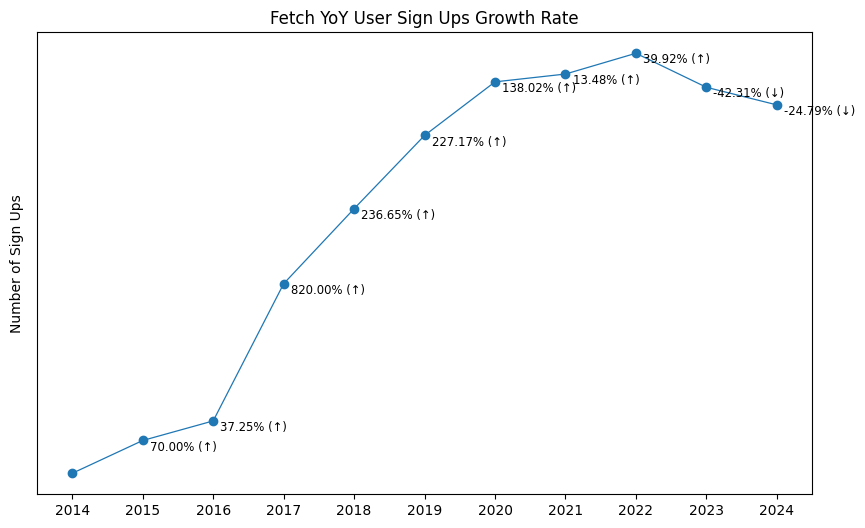

In [46]:
## Calculate year-over-year growth of Fetch users

## Calculate year-over-year growth from the yearly_users
yearly_users = users.groupby(pd.to_datetime(users.CREATED_DATE).dt.year)['ID'].count()
yoy_growth = yearly_users.pct_change() * 100
# print(yoy_growth,'\n\n')

years, num_signups = yearly_users.index, yearly_users.values
yearly_growth_percent = yoy_growth.values

## Plot the users signed up per year
plt.figure(figsize=(10, 6))
plt.plot(years, num_signups, linewidth=0.9)
plt.scatter(years, num_signups)

## Annotating the growth/drop in the number of signed up users for every year after the first year
for x, y, growth_val in zip(years[1:], num_signups[1:], yearly_growth_percent[1:]):
    plt.text(x+0.1, y, f'{growth_val:.2f}% '+('(↓)' if growth_val<0 else '(↑)'), ha='left', va='top', size='small')

plt.title('Fetch YoY User Sign Ups Growth Rate')
plt.xticks(yoy_growth.index)
plt.yscale('log')
plt.ylabel('Number of Sign Ups')
plt.yticks([])
plt.tick_params(axis='y', which='both', left=False)

plt.show()

Fetch saw exponential growth in user sign-ups from 2016 to 2019, with a massive 820% surge in 2017. The momentum of growth kept up through 2021, but started slowing, and by 2023 and 2024, sign-ups dropped by close to 40% and 25%. Even with the recent decline, Fetch's rapid growth in its early years shows just how much it connected with users and took off.